In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%y %H:%M')
df = pd.read_csv('../datatraining.csv', sep=";", parse_dates=True, index_col='date', date_parser=dateparse)
df.head()

,id,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,,
2015-02-04 17:51:00,1,23.18,27.2720,426.0,721.25,0.004793,1
2015-02-04 17:51:00,2,23.15,27.2675,429.5,714.00,0.004783,1
2015-02-04 17:53:00,3,23.15,27.2450,426.0,713.50,0.004779,1
2015-02-04 17:54:00,4,23.15,27.2000,426.0,708.25,0.004772,1
2015-02-04 17:55:00,5,23.10,27.2000,426.0,704.50,0.004757,1


In [3]:
df.loc[df['Light'] == 0, 'Light'] = 1

In [4]:
ts=df['Light']
index = pd.date_range(start=ts.index[0], end=ts.index[len(ts)-1], freq='1min')
ts = pd.Series(ts.values, index)

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


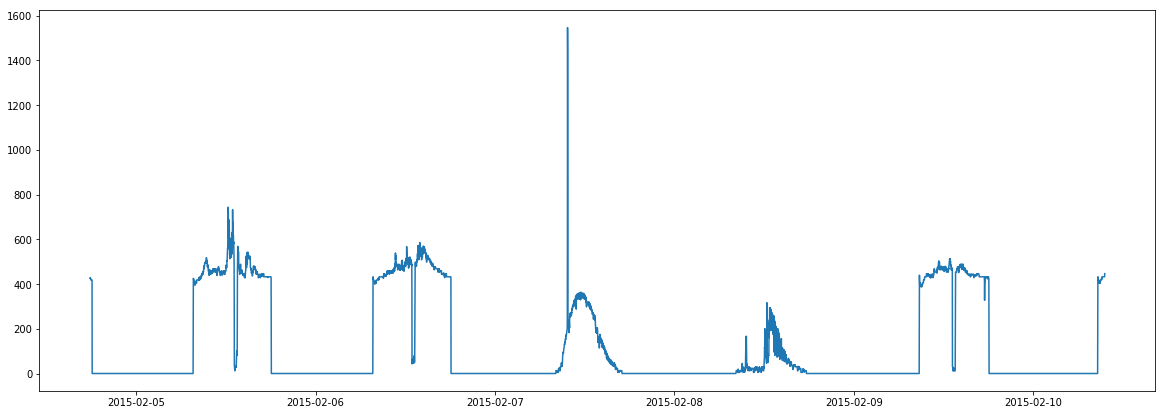

In [5]:
plt.figure(figsize=(20,7))
plt.plot(ts)
plt.show()

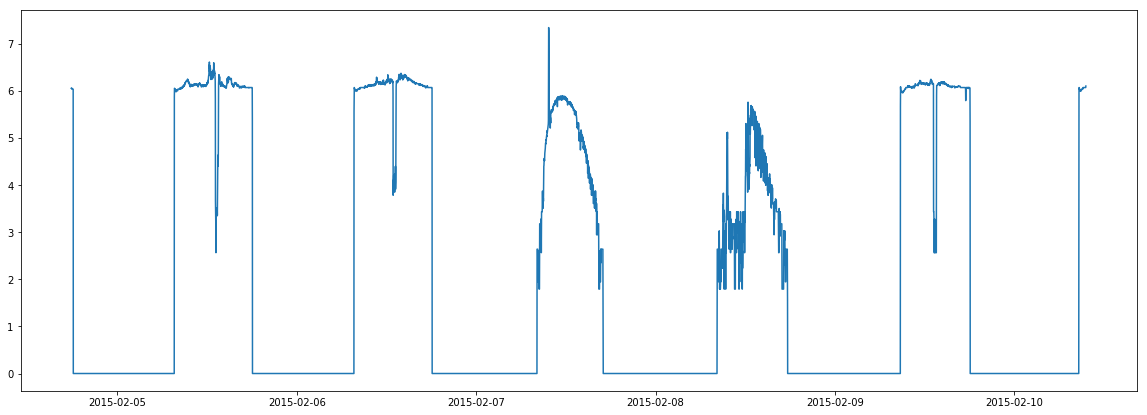

In [6]:
ts_log = pd.Series(np.log(ts), index=ts.index)
plt.figure(figsize=(20,7))
plt.plot(ts_log)
plt.show()

In [7]:
index1 = pd.date_range(start=ts_log.index[0], end=ts_log.index[len(ts)-1], freq='min')
ts1 = pd.Series(ts_log.values, index1)

In [8]:
index1

DatetimeIndex(['2015-02-04 17:51:00', '2015-02-04 17:52:00',
               '2015-02-04 17:53:00', '2015-02-04 17:54:00',
               '2015-02-04 17:55:00', '2015-02-04 17:56:00',
               '2015-02-04 17:57:00', '2015-02-04 17:58:00',
               '2015-02-04 17:59:00', '2015-02-04 18:00:00',
               ...
               '2015-02-10 09:24:00', '2015-02-10 09:25:00',
               '2015-02-10 09:26:00', '2015-02-10 09:27:00',
               '2015-02-10 09:28:00', '2015-02-10 09:29:00',
               '2015-02-10 09:30:00', '2015-02-10 09:31:00',
               '2015-02-10 09:32:00', '2015-02-10 09:33:00'],
              dtype='datetime64[ns]', length=8143, freq='T')

In [9]:
dftest = adfuller(ts1, autolag='AIC')

print('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -3.700680
p-value                           0.004104
#Lags Used                        7.000000
Number of Observations Used    8135.000000
Critical Value (1%)              -3.431154
Critical Value (5%)              -2.861895
Critical Value (10%)             -2.566959
dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


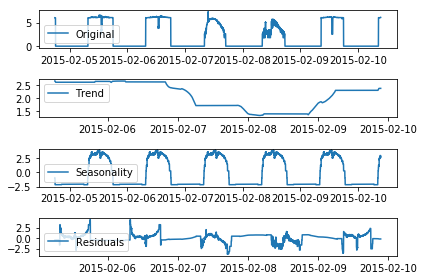

In [10]:
decomposition = sm.tsa.seasonal_decompose(pd.Series(ts1.values, index1), freq=1450)
#decomposition = seasonal_decompose(ts1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts1, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [11]:
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [12]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error


def r2_score(y_true, y_pred, ts):
    mu = np.mean(ts)
    total = np.sum((y_true - mu) ** 2)
    residuals = np.sum((y_true - y_pred) ** 2)
    return 1 - (residuals / total)


def absolute_percentage_error(y_true, y_pred):
    return np.abs((y_true - y_pred) / y_pred)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(absolute_percentage_error(y_true, y_pred))


def max_absolute_percentage_error(y_true, y_pred):
    return np.max(absolute_percentage_error(y_true, y_pred))


def total_absolute_percentage_error(y_true, y_pred):
    return np.sum(absolute_percentage_error(y_true, y_pred))


def evaluate(y_true, y_pred, ts):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAD': median_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred, ts),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'MAXAPE': max_absolute_percentage_error(y_true, y_pred),
        'TAPE': total_absolute_percentage_error(y_true, y_pred)
    }

In [13]:
split_index = 6000
train, test = ts1.iloc[:split_index], ts1.iloc[split_index:]

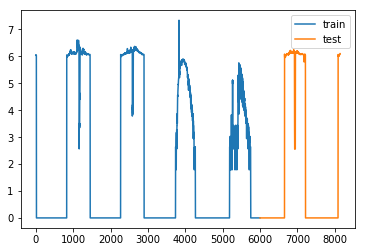

In [14]:
plt.plot(range(split_index), train, label='train')
plt.plot(range(split_index, len(ts1)), test, label='test')
plt.legend()
plt.show()

In [15]:
test.index[0]

Timestamp('2015-02-08 21:51:00', freq='T')

In [16]:
test[0]

0.0

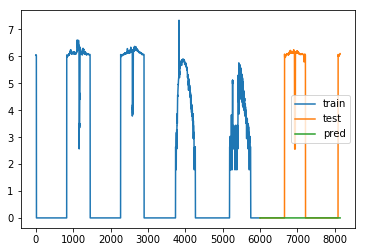

MAE 1.720
RMSE 3.223
MAD 0.000
R2 -0.388
MAPE inf
MAXAPE inf
TAPE inf


In [17]:
smoothing_level = 1
ses = SimpleExpSmoothing(train).fit(smoothing_level=smoothing_level, optimized=True)
pred = ses.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts1).items():
    print('%s %.3f' % (k, v))

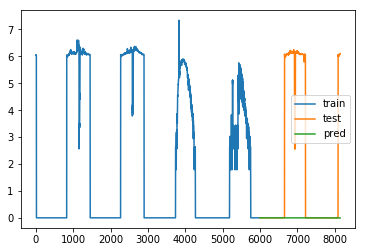

MAE 1.721
RMSE 3.224
MAD 0.003
R2 -0.388
MAPE 1132.847
MAXAPE 5848.831
TAPE 2427691.841


In [18]:
smoothing_level=0.1
smoothing_slope=10

holt = Holt(train).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)
pred = holt.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts1).items():
    print('%s %.3f' % (k, v))

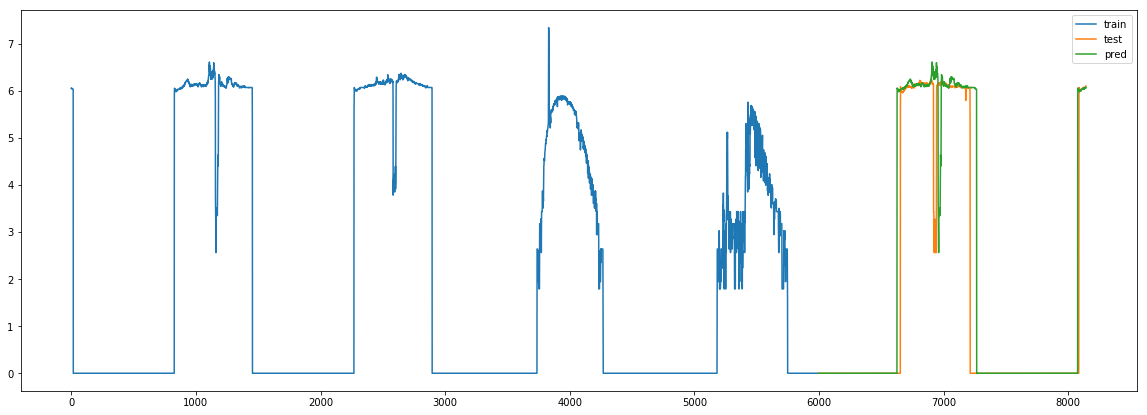

MAE 0.331
RMSE 1.307
MAD 0.000
R2 0.772
MAPE 0.729
MAXAPE 1.406
TAPE 1561.553


In [19]:
seasonal_periods=1450

es = ExponentialSmoothing(train, seasonal_periods=seasonal_periods, trend='add', seasonal='add').fit(smoothing_level=0.3, smoothing_slope=9.705)
pred = es.predict(start=test.index[0], end=test.index[-1])

plt.figure(figsize=(20,7))
plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts1).items():
    print('%s %.3f' % (k, v))

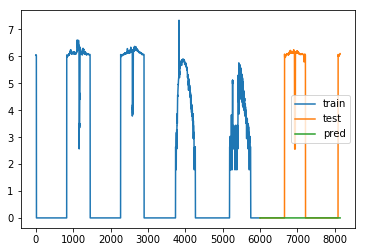

MAE 1.720
RMSE 3.223
MAD 0.000
R2 -0.388
MAPE inf
MAXAPE inf
TAPE inf


In [20]:
sarimax = SARIMAX(train, seasonal_periods=1450).fit(disp=False)
pred = sarimax.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts1).items():
    print('%s %.3f' % (k, v))

In [21]:

import warnings
import itertools
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [22]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            print('ARIMA{} x {} - AIC: {}'.format(param, param_seasonal, results.aic))

            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue
            
print('\nBest Result:', best_result)

ARIMA(0, 0, 0) x (0, 0, 0, 12) - AIC: 31533.219824227952
ARIMA(0, 0, 0) x (0, 0, 1, 12) - AIC: 24816.10917484034
ARIMA(0, 0, 0) x (0, 1, 0, 12) - AIC: 13193.399856888016
ARIMA(0, 0, 0) x (0, 1, 1, 12) - AIC: 12510.911391804688
ARIMA(0, 0, 0) x (1, 0, 0, 12) - AIC: 13104.542760181612
ARIMA(0, 0, 0) x (1, 0, 1, 12) - AIC: 13096.227367999629
ARIMA(0, 0, 0) x (1, 1, 0, 12) - AIC: 12589.585719051584
ARIMA(0, 0, 0) x (1, 1, 1, 12) - AIC: 12508.400747846514
ARIMA(0, 0, 1) x (0, 0, 0, 12) - AIC: 23731.58795416683
ARIMA(0, 0, 1) x (0, 0, 1, 12) - AIC: 17543.5969214725
ARIMA(0, 0, 1) x (0, 1, 0, 12) - AIC: 7839.23676121228
ARIMA(0, 0, 1) x (0, 1, 1, 12) - AIC: 7015.242192493093
ARIMA(0, 0, 1) x (1, 0, 0, 12) - AIC: 7727.388464015661
ARIMA(0, 0, 1) x (1, 0, 1, 12) - AIC: 7597.73445348488
ARIMA(0, 0, 1) x (1, 1, 0, 12) - AIC: 7169.492938787769
ARIMA(0, 0, 1) x (1, 1, 1, 12) - AIC: 7010.62797547093
ARIMA(0, 1, 0) x (0, 0, 0, 12) - AIC: -1523.1350384387868
ARIMA(0, 1, 0) x (0, 0, 1, 12) - AIC: -1506

In [23]:
mod = SARIMAX(test,
            order=(best_result[0][0], best_result[0][1], best_result[0][1]),
            seasonal_order=(best_result[1][0], best_result[1][1], best_result[1][2], best_result[1][3]),
            enforce_stationarity=False,
            enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9971      0.003    302.311      0.000       0.991       1.004
ma.S.L12      -1.0000      4.169     -0.240      0.810      -9.172       7.172
sigma2         0.0504      0.210      0.240      0.811      -0.362       0.463


In [37]:
pred = results.get_prediction(start=test.index[0], dynamic=False)
pred_ci = pred.conf_int()

In [43]:
pred.predicted_mean

2015-02-08 21:51:00    0.000000
2015-02-08 21:52:00    0.000000
2015-02-08 21:53:00    0.000000
2015-02-08 21:54:00    0.000000
2015-02-08 21:55:00    0.000000
2015-02-08 21:56:00    0.000000
2015-02-08 21:57:00    0.000000
2015-02-08 21:58:00    0.000000
2015-02-08 21:59:00    0.000000
2015-02-08 22:00:00    0.000000
2015-02-08 22:01:00    0.000000
2015-02-08 22:02:00    0.000000
2015-02-08 22:03:00    0.000000
2015-02-08 22:04:00    0.000000
2015-02-08 22:05:00    0.000000
2015-02-08 22:06:00    0.000000
2015-02-08 22:07:00    0.000000
2015-02-08 22:08:00    0.000000
2015-02-08 22:09:00    0.000000
2015-02-08 22:10:00    0.000000
2015-02-08 22:11:00    0.000000
2015-02-08 22:12:00    0.000000
2015-02-08 22:13:00    0.000000
2015-02-08 22:14:00    0.000000
2015-02-08 22:15:00    0.000000
2015-02-08 22:16:00    0.000000
2015-02-08 22:17:00    0.000000
2015-02-08 22:18:00    0.000000
2015-02-08 22:19:00    0.000000
2015-02-08 22:20:00    0.000000
                         ...   
2015-02-

In [74]:
for i in range(0,13):
    pred_ci.iloc[i]=(-0.622280, 0.622280)


In [71]:
pred_ci

,lower y,upper y
2015-02-08 21:51:00,-0.538910,0.538910
2015-02-08 21:52:00,-0.538910,0.538910
2015-02-08 21:53:00,-0.538910,0.538910
2015-02-08 21:54:00,-0.538910,0.538910
2015-02-08 21:55:00,-0.538910,0.538910
2015-02-08 21:56:00,-0.538910,0.538910
2015-02-08 21:57:00,-0.538910,0.538910
2015-02-08 21:58:00,-0.538910,0.538910
2015-02-08 21:59:00,-0.538910,0.538910
2015-02-08 22:00:00,-0.538910,0.538910


In [72]:
for i in range(0, len(pred.predicted_mean)):
    if pred.predicted_mean[i]>1000:
        print(pred.predicted_mean[i])

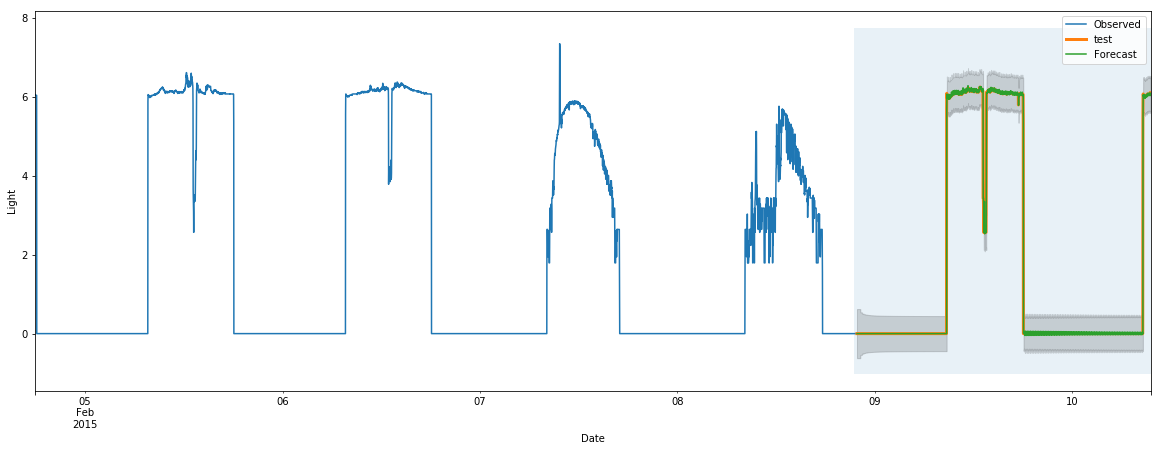

MAE 0.024
RMSE 0.225
MAD 0.006
R2 0.993
MAPE inf
MAXAPE inf
TAPE inf


In [75]:
ax = ts1.plot(label='Observed', figsize=(20, 7))



ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.15)

#pd.to_datetime('2015-02-09')
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-02-08 21:30'), ts.index[-1],
                 alpha=.1, zorder=-1)
test.plot(ax=ax, label='test', linewidth=3)
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Light')
plt.legend()

plt.show()

for k, v in evaluate(test, pred.predicted_mean, ts1).items():
    print('%s %.3f' % (k, v))

In [ ]:
print(results.summary())

In [ ]:
best_result[0][0], best_result[0][1], best_result[0][1]

In [ ]:
best_result[1][0], best_result[1][1], best_result[1][2], best_result[1][3]

In [ ]:
plt.plot(pred)
plt.show()